# Machine Learning Model for Combined Peace River and Caloosahatchee River

This notebook implements a machine learning framework to predict Karenia brevis bloom occurrence across Southwest Florida using integrated environmental and nutrient datasets from the Peace River and Caloosahatchee River watersheds. The analysis combines in situ water quality measurements, hydrologic discharge variables, and confirmed bloom observations, and extends the spatial domain to include the Tampa Bay region. By incorporating data from multiple coastal systems, this workflow evaluates model performance across a broader geographic range and supports regional-scale assessment of bloom prediction capability.

In [1]:
import os
import matplotlib.pyplot as plt
from datetime import datetime

# Define your graphics output directory
graphics_dir = r"C:\Users\mkduu\OneDrive\Documents\FGCU docs\Summer 25 Red Tide Project\Graphics\Final_Graphics"
os.makedirs(graphics_dir, exist_ok=True)

# Define a custom show function to automatically save every figure
_original_show = plt.show

def autosave_show(*args, **kwargs):
    # Get current figure
    fig = plt.gcf()
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    filename = f"figure_{timestamp}.png"
    filepath = os.path.join(graphics_dir, filename)
    fig.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {filepath}")
    _original_show(*args, **kwargs)

# Override the default plt.show
plt.show = autosave_show

## 1. Machine Learning Model

### 1.1 Data Loading and Preprocessing

The merged dataset is loaded and a binary target variable is created to indicate the presence of a Karenia brevis bloom. A bloom event is defined based on whether cell concentrations exceed 100,000 cells/L, with the target shifted one week ahead to support forecasting.

In [2]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split

# Load SWFL merged dataset (with Tampa KB added)
df = pd.read_csv('swfl_merged_features_tampa.csv', parse_dates=['time'])
df = df.sort_values('time').reset_index(drop=True)

# Create binary bloom target (e.g., bloom if kb ≥ 100,000 cells/L)
threshold = 100000
df['bloom'] = (df['kb'] >= threshold).astype(int)

# Create next-week target for 1-week-ahead forecasting
df['target_next_week'] = df['bloom'].shift(-1)
df = df.dropna(subset=['target_next_week'])
df['target_next_week'] = df['target_next_week'].astype(int)

### 1.2 Lag Feature Engineering

Lagged variables and rolling averages are generated for key predictors such as nutrient concentrations, discharge, and ocean conditions. These temporal features provide context on recent environmental trends that may influence bloom dynamics.

In [3]:
# Lag features (1 and 2 weeks back)
df['kb_prev1'] = df['kb'].shift(1)
df['kb_prev2'] = df['kb'].shift(2)

df['zos_prev1'] = df['zos'].shift(1)
df['salinity_prev1'] = df['salinity'].shift(1)
df['water_temp_prev1'] = df['water_temp'].shift(1)
df['wind_speed_prev1'] = df['wind_speed'].shift(1)

df['peace_discharge_prev1'] = df['peace_discharge'].shift(1)
df['peace_TN_prev1'] = df['peace_TN'].shift(1)
df['peace_TP_prev1'] = df['peace_TP'].shift(1)

# Caloosahatchee lag features
df['caloosa_discharge_prev1'] = df['caloosa_discharge'].shift(1)
df['caloosa_TN_prev1'] = df['caloosa_total_nitrogen'].shift(1)
df['caloosa_TP_prev1'] = df['caloosa_total_phosphorus'].shift(1)

# Rolling average (4-week) of Peace discharge
df['discharge_4w_avg'] = df['peace_discharge'].rolling(window=4).mean()

# Drop rows with NaNs created by shifting
df.dropna(inplace=True)

### 1.3 Feature Selection

Relevant features, including both current and lagged environmental variables, are selected for use in the machine learning model. These features represent potential drivers of bloom events across both the Peace River and Caloosahatchee River systems.

In [4]:
feature_cols = [
    'kb', 'kb_prev1', 'kb_prev2',
    'zos', 'salinity', 'water_temp',
    'wind_speed', 'wind_direction',
    'peace_discharge', 'peace_TN', 'peace_TP',
    'peace_discharge_prev1', 'peace_TN_prev1', 'peace_TP_prev1',
    'caloosa_discharge', 'caloosa_total_nitrogen', 'caloosa_total_phosphorus',
    'caloosa_discharge_prev1', 'caloosa_TN_prev1', 'caloosa_TP_prev1',
    'discharge_4w_avg'
]


### 1.4 Train-Test Split and Scaling

The dataset is split chronologically into training and testing sets to preserve temporal structure. A RobustScaler is applied to normalize the feature distributions and reduce sensitivity to outliers commonly present in hydrological and ecological data.

In [5]:
# Split into train/test by date
train_df = df[df['time'] < '2019-01-01']
test_df  = df[df['time'] >= '2019-01-01']

X_train = train_df[feature_cols]
y_train = train_df['target_next_week']
X_test  = test_df[feature_cols]
y_test  = test_df['target_next_week']

# Scale Features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

### 1.5 Model Training

A Random Forest classifier is trained on the scaled training set and evaluated on the test set. Model performance is assessed using classification metrics to determine predictive accuracy for one-week-ahead bloom conditions.

In [6]:
# Train Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_clf.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = rf_clf.predict(X_test_scaled)

from sklearn.metrics import classification_report, balanced_accuracy_score
print(classification_report(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       172
           1       0.91      0.79      0.85        87

    accuracy                           0.90       259
   macro avg       0.90      0.88      0.89       259
weighted avg       0.90      0.90      0.90       259

Balanced Accuracy: 0.8762028869286287


### 1.6 Results Summary

Incorporating *Karenia brevis* cell counts from the Tampa Bay region resulted in a modest improvement in model performance. The **balanced accuracy** increased from **0.855** (original dataset) to **0.876** with Tampa data. Notably, the **recall for bloom events (class 1)** improved from **0.75 to 0.79**, indicating the model's enhanced ability to correctly identify bloom conditions. Precision and overall accuracy remained stable at **0.90**, suggesting that including Tampa KB data improved bloom detection sensitivity without compromising classification reliability.

## 2. ML Evaluation

### 2.1 Confusion Matrix

In [7]:
from sklearn.metrics import classification_report
import pandas as pd

# Get classification report as dictionary
report_dict = classification_report(
    y_test, y_pred, target_names=["No Bloom", "Bloom"], output_dict=True
)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Optional: round for display
report_df = report_df.round(2)

# Display the table
report_df

,precision,recall,f1-score,support
No Bloom,0.90,0.96,0.93,172.0
Bloom,0.91,0.79,0.85,87.0
accuracy,0.90,0.90,0.90,0.9
macro avg,0.90,0.88,0.89,259.0
weighted avg,0.90,0.90,0.90,259.0


Figure saved to: C:\Users\mkduu\OneDrive\Documents\FGCU docs\Summer 25 Red Tide Project\Graphics\Final_Graphics\figure_2025-12-29_18-02-52.png


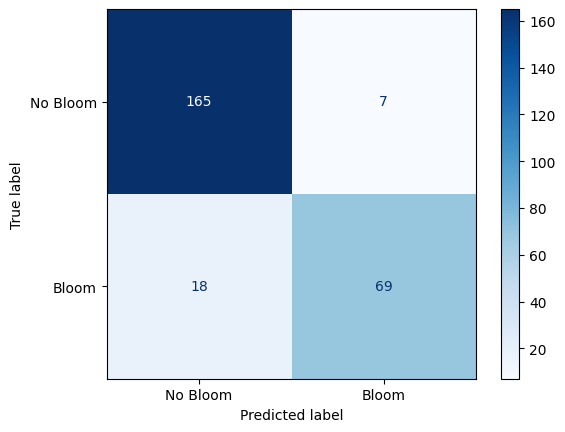

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot with updated title
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Bloom", "Bloom"])
disp.plot(cmap="Blues", values_format="d")
plt.show()

### Confusion Matrix: Random Forest Performance on *Karenia brevis* Bloom Forecasting

The confusion matrix visually represents the performance of your machine learning classification model—in this case, the Random Forest classifier used to predict *Karenia brevis* bloom severity. A confusion matrix summarizes the number of correct and incorrect predictions, broken down by each class ("No Bloom" and "Bloom").

The confusion matrix has four key components:

|                  | Predicted No Bloom | Predicted Bloom |
|------------------|--------------------|-----------------|
| Actual No Bloom | True Negative (TN) – 165 | False Positive (FP) – 7 |
| Actual Bloom    | False Negative (FN) – 18 | True Positive (TP) – 69 |

1. **True Negative (TN) = 165**  
   - The model correctly predicted "No Bloom" when there was actually no bloom.  
2. **False Positive (FP) = 7**  
   - The model predicted "Bloom" when there was actually no bloom (a false alarm).  
3. **False Negative (FN) = 18**  
   - The model predicted "No Bloom" when there was actually a bloom (a missed bloom event).  
4. **True Positive (TP) = 69**  
   - The model correctly predicted "Bloom" when there was actually a bloom.  

###### Key Metrics Derived from the Confusion Matrix:
1. **Accuracy** – Measures the overall percentage of correct predictions:
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} = \frac{69 + 165}{69 + 165 + 7 + 18} = \frac{234}{259} \approx 0.90 \quad (90\%)
$$

2. **Precision** – Measures how many of the predicted positive cases (blooms) were actually correct:
$$
\text{Precision} = \frac{TP}{TP + FP} = \frac{69}{69 + 7} \approx 0.91 \quad (91\%)
$$
- High precision means fewer false positives (the model doesn’t incorrectly predict blooms very often).

3. **Recall (Sensitivity or True Positive Rate)** – Measures how many of the actual positive cases (blooms) were correctly identified:
$$
\text{Recall} = \frac{TP}{TP + FN} = \frac{69}{69 + 18} \approx 0.79 \quad (79\%)
$$
- High recall means the model catches most of the bloom events.

4. **F1-Score** – The harmonic mean of precision and recall; it balances the trade-off between precision and recall:
$$
\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} = 2 \cdot \frac{0.91 \cdot 0.79}{0.91 + 0.79} \approx 0.85 \quad (85\%)
$$
- A high F1-score means the model achieves a good balance between precision and recall.

5. **Support** – The number of actual samples in each class:
   - No Bloom: 172 total instances  
   - Bloom: 87 total instances  

###### Summary of Model Performance:
- The model correctly predicted 90% of the test samples (accuracy).  
- It had a high precision of 91%, meaning it rarely issued false bloom alerts.  
- The recall of 79% indicates that the model detected most bloom events and reduced false negatives compared to the baseline model.  
- The F1-score of 85% reflects that the model maintains a strong balance between precision and recall.  

###### Conclusion:  
- The model demonstrates strong performance in predicting *Karenia brevis* bloom conditions using the enhanced dataset that includes Tampa KB values.  
- The increase in recall and F1-score over the original SWFL-only model suggests that the additional data improved bloom detection.  
- Continued feature refinement or threshold tuning may help push recall even higher while maintaining precision.


### 2.2 Precision-Recall Curve

his is a Precision-Recall (PR) Curve, which illustrates the trade-off between precision and recall at different classification thresholds for the Random Forest model trained on the combined Southwest Florida dataset (Peace River + Caloosahatchee River).

##### What the PR Curve Represents:
- **Precision (Y-axis)** = The proportion of predicted positive cases that are truly positive:
$$
\text{Precision} = \frac{TP}{TP + FP}
$$

- **Recall (X-axis)** = The proportion of actual positive cases that are correctly predicted:
$$
\text{Recall} = \frac{TP}{TP + FN}
$$

The PR curve evaluates the model’s performance across a range of thresholds, showing how precision changes as recall increases. High recall means the model captures more true blooms but may increase false positives, lowering precision. Conversely, high precision means fewer false alarms but may miss some bloom events.

In this model, the classifier maintains strong precision (~0.91) even as recall increases toward 0.79 — demonstrating the model’s ability to detect true bloom events while minimizing false alarms. A notable drop in precision occurs only at the highest recall levels (>0.90), indicating that aggressively trying to catch every bloom comes at the cost of including more false positives — a common trade-off in environmental risk forecasting.

This curve aligns with the model’s **F1-score of 85%** and **balanced accuracy of 87.6%**, both of which reflect improved predictive strength compared to the baseline model. The curve suggests that the model balances bloom sensitivity and specificity effectively under the default threshold. Depending on monitoring goals, the classification threshold can be adjusted to prioritize early detection (higher recall) or conservative alerts (higher precision). The **F1-score** or the **area under the precision-recall curve (PR AUC)** can help guide optimal threshold selection for operational use.


Figure saved to: C:\Users\mkduu\OneDrive\Documents\FGCU docs\Summer 25 Red Tide Project\Graphics\Final_Graphics\figure_2025-12-29_18-02-53.png


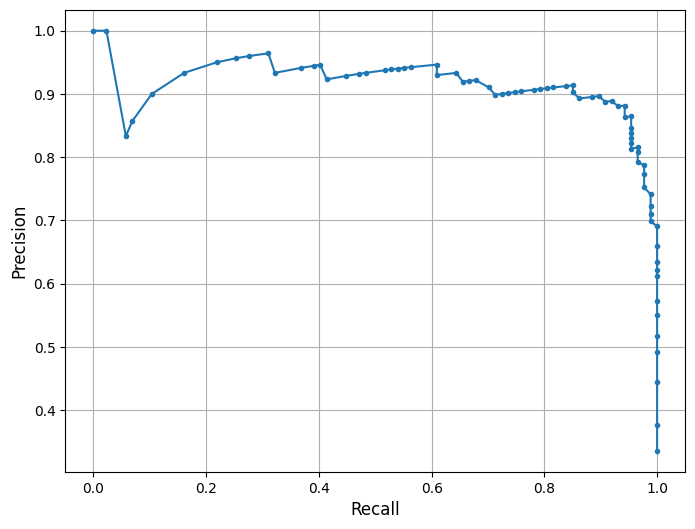

In [9]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import os

# Optional: save to your custom graphics folder
graphics_dir = r"C:\Users\mkduu\OneDrive\Documents\FGCU docs\Summer 25 Red Tide Project\Graphics\Final_Graphics"
os.makedirs(graphics_dir, exist_ok=True)

# Compute precision and recall
precision, recall, _ = precision_recall_curve(y_test, rf_clf.predict_proba(X_test_scaled)[:, 1])

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', linewidth=1.5)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.grid(True)

# Save plot
plt.savefig(os.path.join(graphics_dir, "PR_curve_SWFL_Tampa.png"), dpi=300, bbox_inches='tight')
plt.show()

### 2.3 Feature Importance Plot

The plot from the Random Forest Classifier shows the relative contribution of each input feature to predicting *Karenia brevis* bloom severity. Feature importance reflects how much each feature reduces classification error, based on improvements in the Gini index across all decision trees in the ensemble.

*Karenia brevis* cell counts (`kb`) remain the most dominant predictor, with lagged values (`kb_prev2`, `kb_prev1`) also ranking near the top. This highlights the strong short-term autocorrelation of bloom conditions — a bloom this week is highly predictive of bloom presence in the near future.

Discharge dynamics, especially the **4-week rolling average** (`discharge_4w_avg`) and **lagged Peace River discharge** (`peace_discharge_prev1`), continue to be important secondary contributors. Nutrient inputs — including `peace_TN_prev1`, `caloosa_TN_prev1`, and `caloosa_total_phosphorus` — also influence bloom status, supporting the hypothesis that nitrogen and phosphorus availability play a key role in bloom maintenance and short-term intensification.

Oceanographic variables such as `zos` (sea level anomaly) and `water_temp` show modest importance, while `salinity`, `wind_speed`, and `wind_direction` contribute less overall. These likely represent more variable or indirect effects on bloom behavior (e.g., transport, mixing).

These results reinforce that the strongest bloom predictors are recent KB levels, followed by discharge and nutrient signals — while atmospheric and oceanic conditions provide supporting context in bloom forecasting.

Figure saved to: C:\Users\mkduu\OneDrive\Documents\FGCU docs\Summer 25 Red Tide Project\Graphics\Final_Graphics\figure_2025-12-29_18-02-53.png


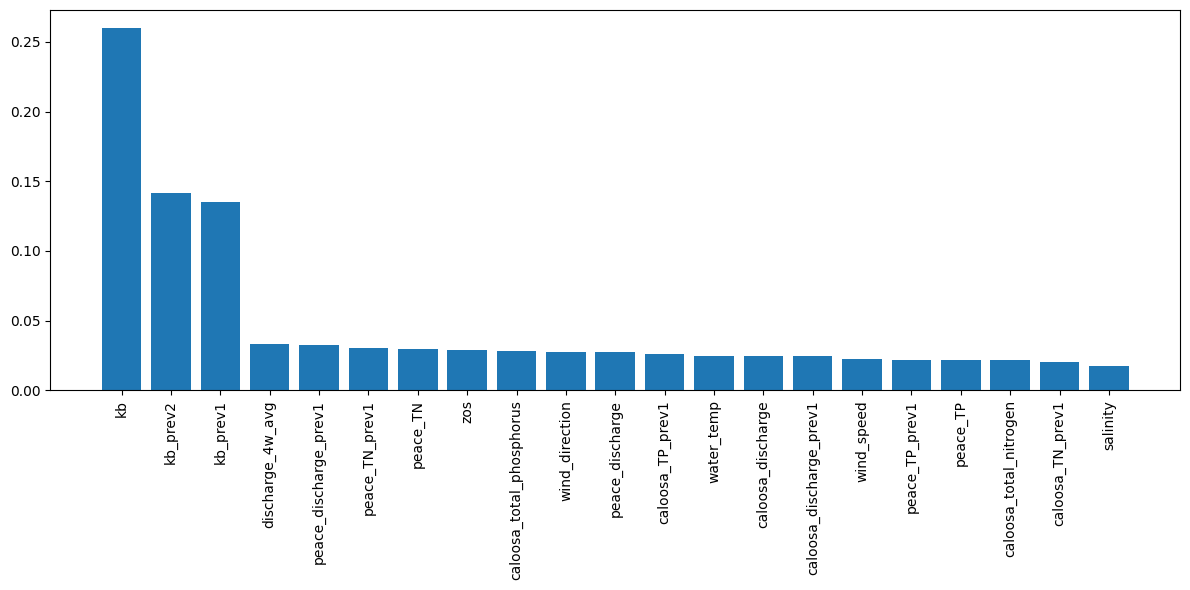

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Get feature importances from the trained RF model
importances = rf_clf.feature_importances_

# Sort feature indices from most to least important
indices = np.argsort(importances)[::-1]

# Optional: Save to your custom graphics directory
graphics_dir = r"C:\Users\mkduu\OneDrive\Documents\FGCU docs\Summer 25 Red Tide Project\Graphics\Final_Graphics"
os.makedirs(graphics_dir, exist_ok=True)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [feature_cols[i] for i in indices], rotation=90)
plt.tight_layout()

# Save figure
plt.savefig(os.path.join(graphics_dir, "feature_importances_SWFL_Tampa.png"), dpi=300, bbox_inches="tight")
plt.show()

### 2.4 Partial Dependence Plots

Partial dependence plots (PDPs) illustrate how predicted *Karenia brevis* bloom probabilities respond to changes in river discharge and nutrient concentrations from both the Peace and Caloosahatchee Rivers, while holding all other variables constant. The y-axis represents the model’s predicted bloom probability, and the x-axis shows the standardized values of each input feature.

For both `peace_discharge` and `caloosa_discharge`, bloom probability increases sharply from low to moderate discharge values and then flattens out. This suggests that moderate freshwater inflows may promote bloom persistence or nutrient delivery, while higher discharge may not further increase bloom probability — potentially due to dilution or reduced residence time.

Nutrient variables show more varied but similarly nonlinear behavior. For example, `peace_TN` and `caloosa_total_nitrogen` are both associated with increasing bloom probability up to a threshold (~2–3 mg/L), after which the effect plateaus. This indicates a possible nitrogen saturation point, beyond which blooms are no longer limited by nitrogen availability.

Phosphorus variables — `peace_TP` and `caloosa_total_phosphorus` — follow the same pattern: steep initial increases in bloom probability at low phosphorus concentrations, followed by tapering or even a gradual decline beyond ~1.5 mg/L. This may reflect a stoichiometric imbalance or ecological thresholds where additional phosphorus no longer promotes bloom activity.

The clustering of tick marks along the lower end of the x-axes indicates that most training data points fall within those value ranges, reinforcing that model predictions are more reliable there. These PDPs collectively show that bloom risk is most sensitive to moderate discharge and nutrient conditions, consistent with ecological dynamics of nutrient triggering, hydrologic influence, and possible saturation effects in bloom formation.


Figure saved to: C:\Users\mkduu\OneDrive\Documents\FGCU docs\Summer 25 Red Tide Project\Graphics\Final_Graphics\figure_2025-12-29_18-03-00.png


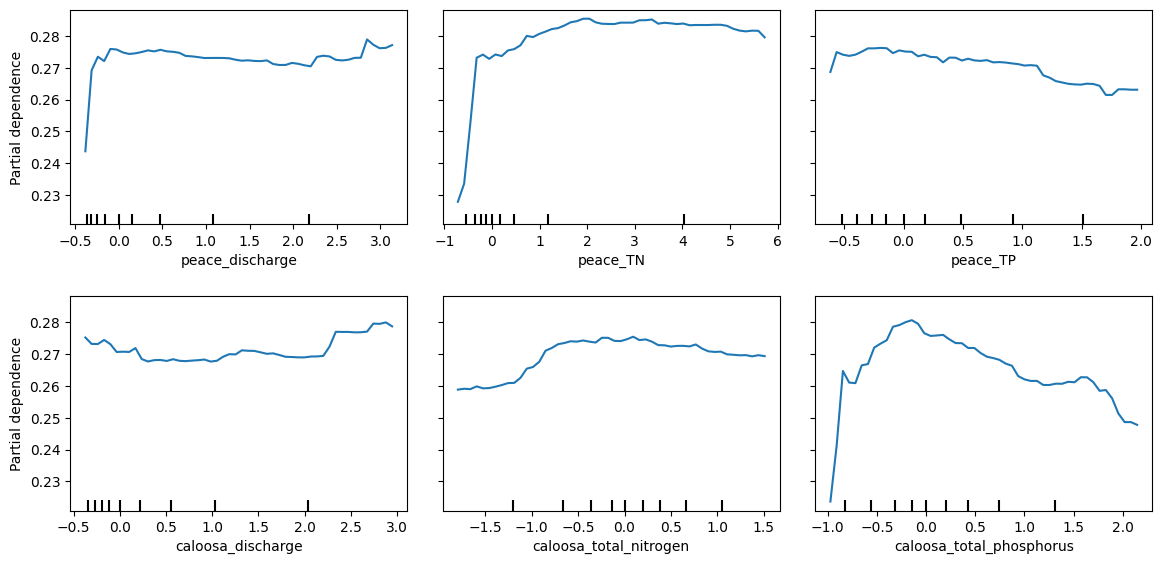

In [11]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
graphics_dir = r"C:\Users\mkduu\OneDrive\Documents\FGCU docs\Summer 25 Red Tide Project\Graphics\Final_Graphics"
os.makedirs(graphics_dir, exist_ok=True)

## Select features to plot
selected_features = [
    feature_cols.index('peace_discharge'),
    feature_cols.index('peace_TN'),
    feature_cols.index('peace_TP'),
    feature_cols.index('caloosa_discharge'),
    feature_cols.index('caloosa_total_nitrogen'),
    feature_cols.index('caloosa_total_phosphorus')
]

# Create PDP plots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

PartialDependenceDisplay.from_estimator(
    rf_clf,
    X_train_scaled,
    features=selected_features,
    feature_names=feature_cols,
    grid_resolution=50,
    ax=ax
)

# Adjust layout to avoid cutoff & save
plt.tight_layout(pad=2.0)
plt.savefig(os.path.join(graphics_dir, "partial_dependence_SWFL_Tampa.png"), dpi=300, bbox_inches='tight')
plt.show()

### 2.5 Actual Vs. Predicted Bloom

This figure shows the actual vs. predicted *Karenia brevis* bloom status over time for the updated model that incorporates Tampa-area KB data into the Southwest Florida (SWFL) system. The model’s predictions (red dashed line) align closely with observed bloom events (blue line), capturing both the onset and duration of bloom episodes with high temporal fidelity.

The model slightly underpredicts bloom persistence in a few intervals — where actual bloom duration extends beyond predicted — but overprediction is minimal. In most cases, the model accurately identifies bloom start dates and avoids premature false positives. Compared to the baseline model, this updated version demonstrates improved alignment with observed blooms and fewer lagging or premature activations.

These results indicate that incorporating KB data from Tampa enhances the model’s ability to learn bloom dynamics across the region. The consistent agreement between actual and predicted time series confirms that the model captures short-term bloom memory and seasonal signals effectively, suggesting it is well-suited for real-time bloom surveillance and early warning applications in multi-basin systems like SWFL.


Figure saved to: C:\Users\mkduu\OneDrive\Documents\FGCU docs\Summer 25 Red Tide Project\Graphics\Final_Graphics\figure_2025-12-29_18-03-01.png


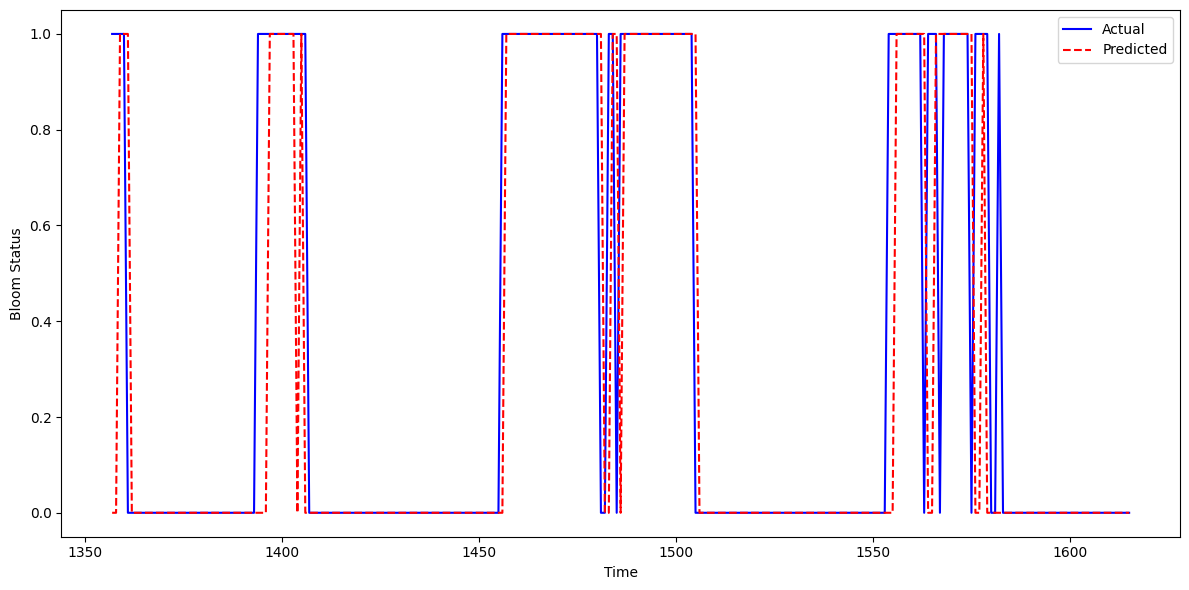

In [12]:
import matplotlib.pyplot as plt
import os
import pandas as pd

# Ensure output folder exists
output_dir = r"C:\Users\mkduu\OneDrive\Documents\FGCU docs\Summer 25 Red Tide Project\Graphics\Final_Graphics"
os.makedirs(output_dir, exist_ok=True)

# Create DataFrame to hold test results
test_df = pd.DataFrame({
    'time': X_test.index,  # assumes X_test is indexed by time
    'Actual': y_test,
    'Predicted': y_pred
})

# Sort by time for plotting
test_df = test_df.sort_values('time')

# Plot actual vs predicted bloom status
plt.figure(figsize=(12, 6))
plt.plot(test_df['time'], test_df['Actual'], label='Actual', color='blue')
plt.plot(test_df['time'], test_df['Predicted'], label='Predicted', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Bloom Status')
plt.legend()
plt.tight_layout()

# Save updated figure
plt.savefig(os.path.join(output_dir, 'actual_predicted_SWFL_Tampa.png'), dpi=300, bbox_inches='tight')
plt.show()

### 2.6 Learning Curve

The learning curve below illustrates the model’s performance as the training set size increases. It plots training accuracy (blue) and validation accuracy (orange) to help assess model generalization and overfitting behavior.

- **Training Score (Blue Line at 1.00)**:  
  The model achieves **perfect accuracy** on the training set across all sample sizes, indicating potential **overfitting**. This suggests the model memorizes the training data exceptionally well.

- **Validation Score (Orange Line)**:  
  Validation accuracy begins around **0.72** and steadily increases, plateauing around **0.84**. This trend shows that the model generalizes better as more data becomes available and benefits from a larger training set.

- **Gap Between Training and Validation**:  
  The persistent gap between the training and validation scores highlights a **generalization gap**. The model performs very well on seen data but does not achieve the same level of accuracy on unseen data.

---

**Interpretation**

- The Random Forest model shows strong memorization capability but limited generalization, suggesting high model capacity.
- The plateau in validation performance (~84%) implies the model has learned most of the signal available in the data.
- This learning curve confirms that while the model is accurate and stable, further refinements may enhance its robustness in operational bloom forecasting.


Figure saved to: C:\Users\mkduu\OneDrive\Documents\FGCU docs\Summer 25 Red Tide Project\Graphics\Final_Graphics\figure_2025-12-29_18-03-12.png


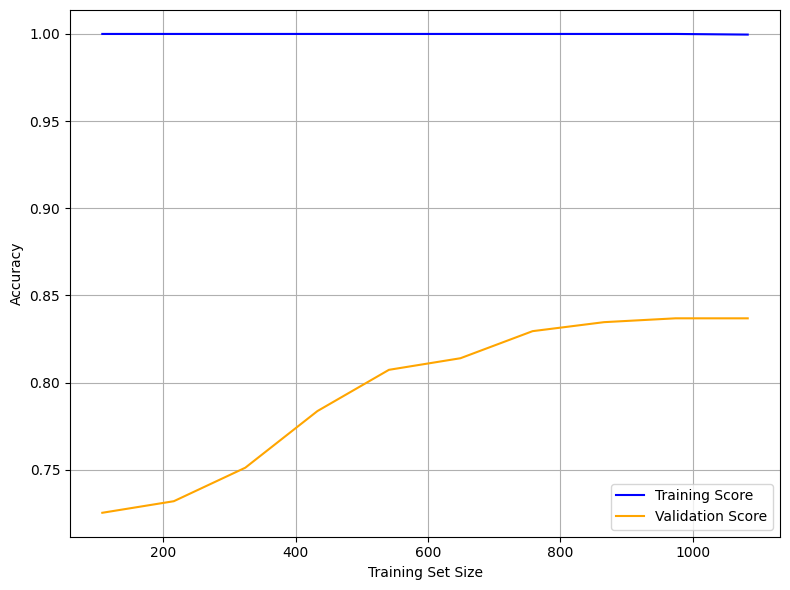

In [13]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
import os

# Create output directory if it doesn't exist
output_dir = r"C:\Users\mkduu\OneDrive\Documents\FGCU docs\Summer 25 Red Tide Project\Graphics\Final_Graphics"
os.makedirs(output_dir, exist_ok=True)

# Generate Learning Curve data
train_sizes, train_scores, test_scores = learning_curve(
    rf_clf,
    X_train_scaled,
    y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute mean scores across folds
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Plot Learning Curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_mean, label='Validation Score', color='orange')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'learning_curve_SWFL_Tampa.png'), dpi=300, bbox_inches='tight')
plt.show()

### 2.7 Pair Plot

The pair plot below displays the relationships and distributions among *Karenia brevis* cell concentrations (`kb`), river discharge, and nutrient levels from both the Peace and Caloosahatchee Rivers using the updated dataset that includes Tampa KB data.

1. All nutrient and discharge variables continue to exhibit strong right-skewed distributions, with most values clustered at the low end and occasional extreme values. This reflects episodic nutrient surges and discharge events, which are typical of coastal watershed systems.

2. While linear correlations between `kb` and other variables remain weak, the plot reveals key clustering patterns — particularly, higher `kb` values tend to coincide with moderate levels of river discharge (`peace_discharge`, `caloosa_discharge`) and elevated nutrient concentrations (`peace_TN`, `caloosa_total_nitrogen`), suggesting bloom activity may be triggered or sustained by these conditions.

3. Nutrient distributions remain consistent between the two rivers, and both nitrogen and phosphorus variables show wide variability, reinforcing their role as co-drivers of bloom events. Notably, the inclusion of Tampa KB data does not introduce conflicting trends, indicating the broader regional coherence of bloom-nutrient-discharge relationships.

These patterns suggest that *Karenia brevis* bloom dynamics are governed by nonlinear, episodic processes involving both nutrient inputs and hydrological forcing from multiple rivers. The Tampa KB data strengthens the ecological signal, supporting the idea that spatially aggregated bloom data can still yield consistent and informative predictors of bloom risk.


Figure saved to: C:\Users\mkduu\OneDrive\Documents\FGCU docs\Summer 25 Red Tide Project\Graphics\Final_Graphics\figure_2025-12-29_18-03-20.png


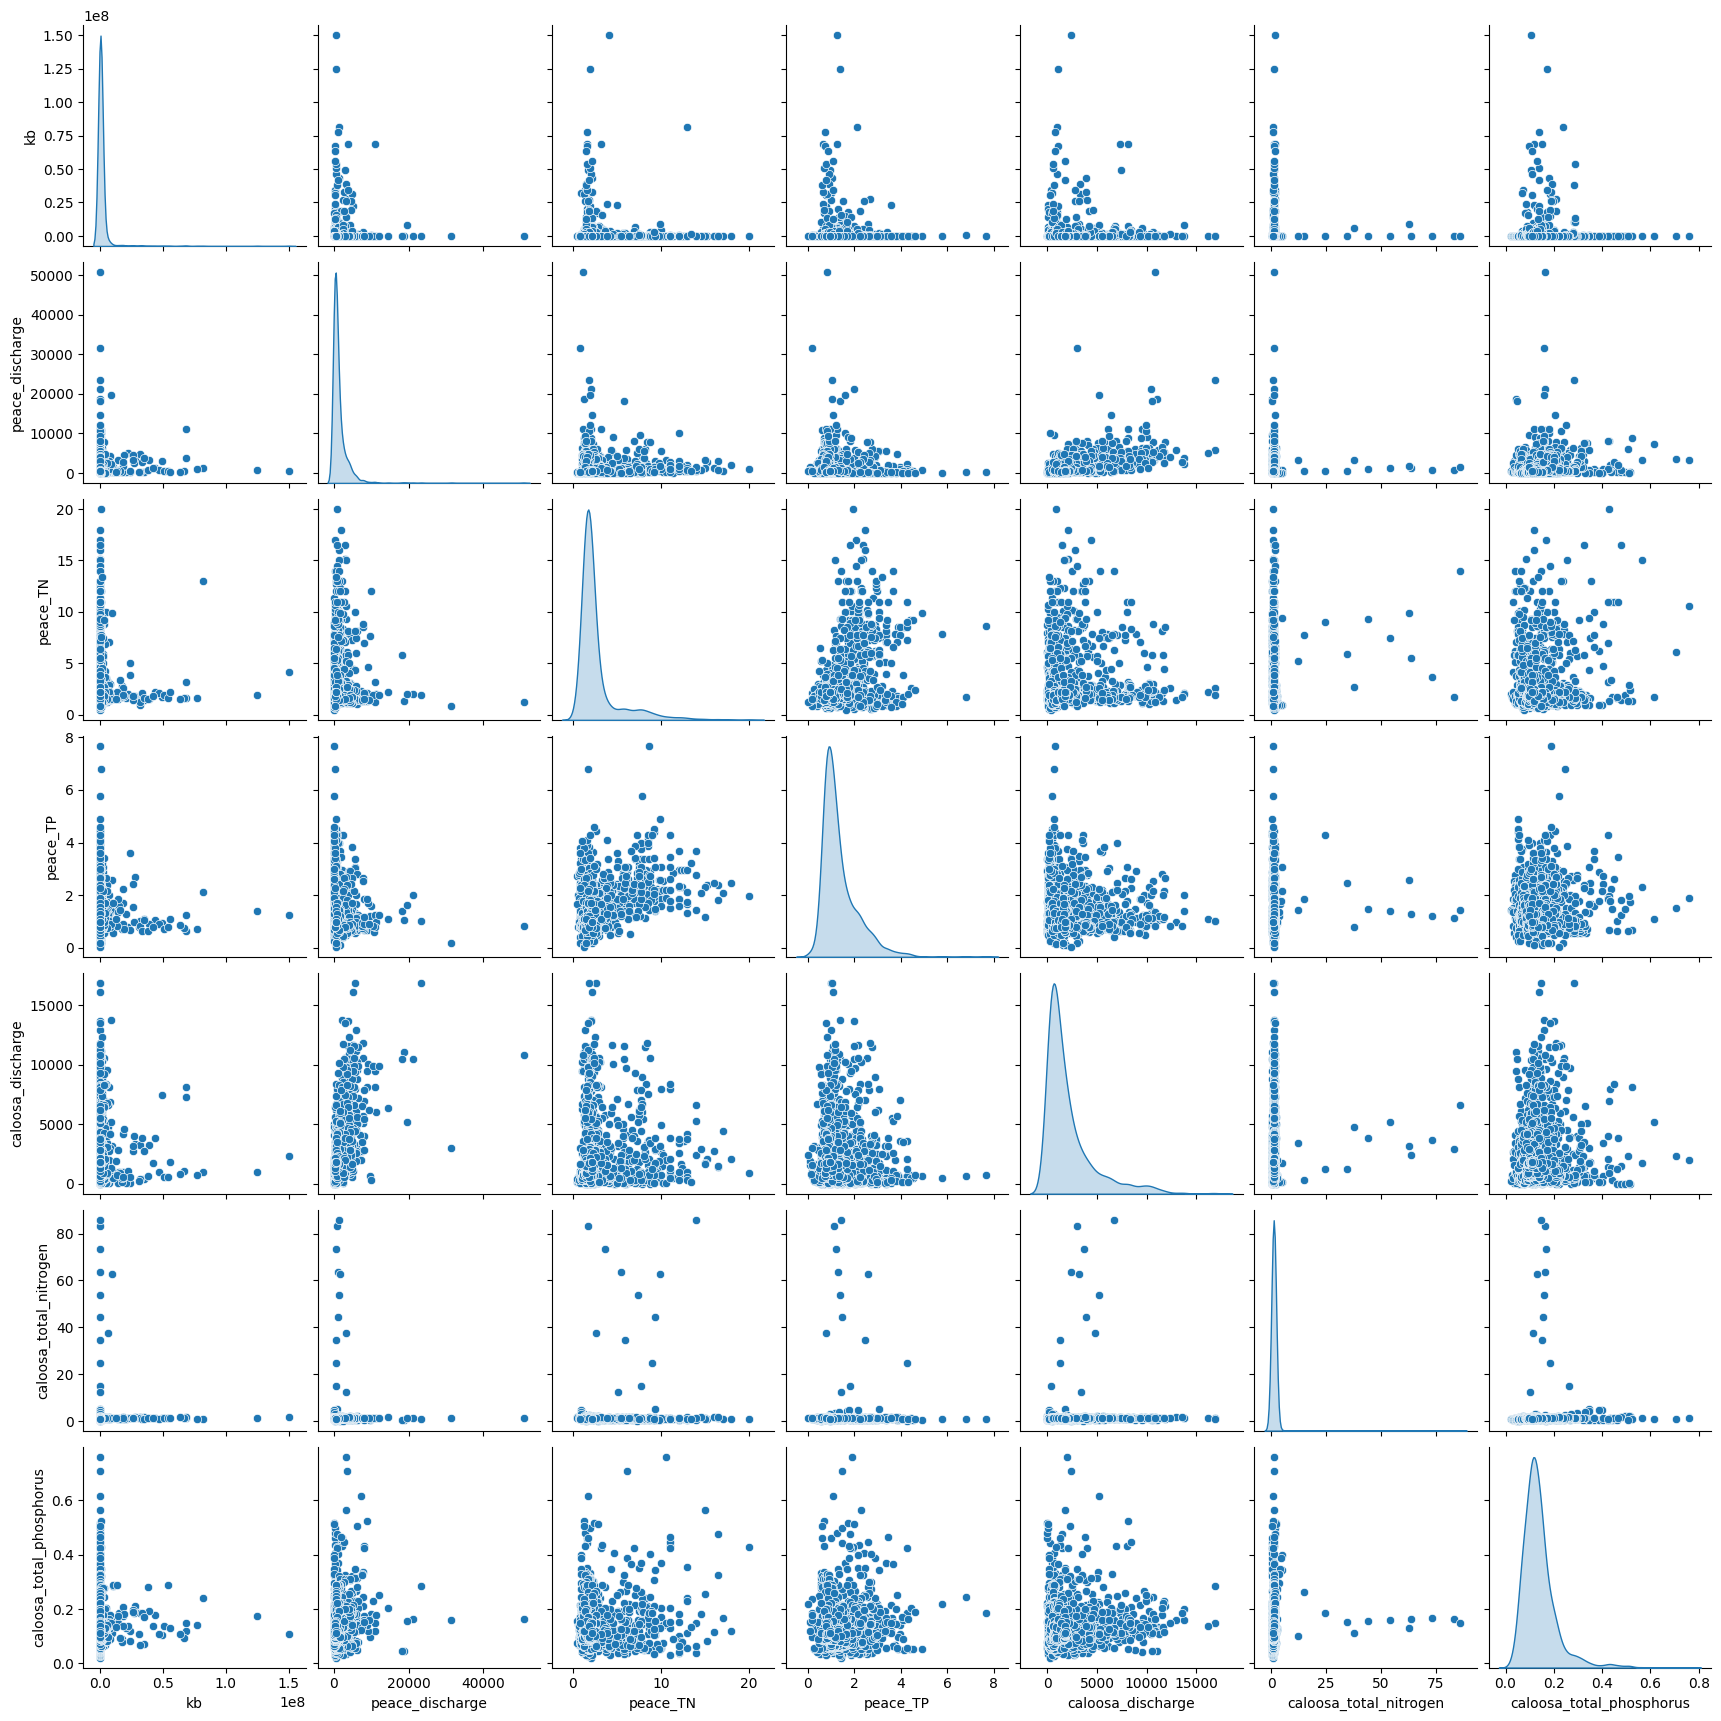

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd

# Load the merged SWFL + Tampa KB dataset
df_swfl_merged = pd.read_csv("swfl_merged_features_tampa.csv")

# Ensure figures folder exists
os.makedirs("Figures", exist_ok=True)

# Select relevant variables for pair plot
pairplot_vars = [
    'kb', 'peace_discharge', 'peace_TN', 'peace_TP',
    'caloosa_discharge', 'caloosa_total_nitrogen', 'caloosa_total_phosphorus'
]

# Generate pair plot
sns.pairplot(df_swfl_merged[pairplot_vars], diag_kind='kde')
plt.savefig("Figures/pair_plot_SWFL_Tampa.png", dpi=300, bbox_inches='tight')
plt.show()

## 3. XGBoost Model

We implemented **XGBoost (Extreme Gradient Boosting)** as an alternative machine learning model to predict harmful algal bloom (HAB) events one week in advance. XGBoost is a high-performance, tree-based algorithm known for its ability to model complex, nonlinear relationships in structured tabular data. It builds decision trees sequentially, with each new tree correcting the errors of the previous one — making it particularly effective for classification tasks.

We selected XGBoost because:
- It handles **imbalanced datasets** well using the `scale_pos_weight` parameter.
- It often outperforms traditional methods like Random Forest in predictive accuracy when properly tuned.
- It allows for **fine-grained control** over learning behavior and regularization to reduce overfitting.

In [15]:
# Import necessary libraries
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split

# Define feature columns and target
features = [
    'kb', 'kb_prev1', 'kb_prev2',
    'zos', 'salinity', 'water_temp',
    'wind_speed', 'wind_direction',
    'peace_discharge', 'peace_TN', 'peace_TP',
    'peace_discharge_prev1', 'peace_TN_prev1', 'peace_TP_prev1',
    'caloosa_discharge', 'caloosa_total_nitrogen', 'caloosa_total_phosphorus',
    'caloosa_discharge_prev1', 'caloosa_TN_prev1', 'caloosa_TP_prev1',
    'discharge_4w_avg'
]

target = 'target_next_week'

# Split into train and test
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Compute class weight ratio
class_weight_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

# Initialize and fit XGBoost model
xgb_model = XGBClassifier(
    scale_pos_weight=class_weight_ratio,  # handle imbalance
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)

print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["No Bloom", "Bloom"]))

Balanced Accuracy: 0.810064935064935
Confusion Matrix:
 [[201  30]
 [ 23  69]]
Classification Report:
               precision    recall  f1-score   support

    No Bloom       0.90      0.87      0.88       231
       Bloom       0.70      0.75      0.72        92

    accuracy                           0.84       323
   macro avg       0.80      0.81      0.80       323
weighted avg       0.84      0.84      0.84       323



C:\Users\mkduu\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:03:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### XGBoost Model Performance Summary

The XGBoost classifier demonstrated solid performance in predicting *Karenia brevis* bloom events one week in advance using the Southwest Florida (SWFL) dataset with the inclusion of Tampa KB data. The model achieved an overall **accuracy of 84%** and a **balanced accuracy of 81.0%**, indicating good predictive capability across both bloom and non-bloom classes.

---

#### Class-Specific Performance:

- **No Bloom:**
  - Precision: **0.90**
  - Recall: **0.87**
  - F1-score: **0.88**
  - Support: 231 samples

- **Bloom:**
  - Precision: **0.70**
  - Recall: **0.75**
  - F1-score: **0.72**
  - Support: 92 samples

The classifier continues to perform well for **no-bloom predictions**, with high precision and recall. For bloom predictions, the model captures **75% of true bloom events**, a slight drop from the Random Forest baseline but still effective for early-warning applications. The **precision of 0.70** suggests moderate false positives, which may be acceptable depending on monitoring priorities.

---

#### Overall Averages:

- **Macro average F1-score:** **0.80**
- **Weighted average F1-score:** **0.84**

---

#### Confusion Matrix Summary:

|                        | Predicted No Bloom | Predicted Bloom |
|------------------------|--------------------|-----------------|
| **Actual No Bloom**    | 201                | 30              |
| **Actual Bloom**       | 23                 | 69              |

---

These results suggest that the XGBoost model effectively captures bloom dynamics and offers a **reasonable trade-off between recall and precision**, even without fine-tuned hyperparameters. Although it slightly underperforms compared to the best-performing Random Forest configuration, it remains **a reliable and interpretable model**. With further tuning, XGBoost could become a strong operational forecasting tool for *Karenia brevis* blooms in Southwest Florida.


### 3.1 Quick Hyperparameter Tuning with RandomizedSearchCV

To improve the performance of the XGBoost model, we performed a quick hyperparameter tuning using `RandomizedSearchCV`. This approach samples a subset of possible parameter combinations rather than evaluating all combinations exhaustively. We used 20 random trials and 3-fold cross-validation to identify a better-performing configuration.

The hyperparameters tested included tree depth, learning rate, number of estimators, and subsampling ratios. We maintained class imbalance handling by preserving the `scale_pos_weight`. The optimized model was then evaluated on the test set to assess whether it improved bloom prediction performance over the original configuration.

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np

# Define parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'scale_pos_weight': [class_weight_ratio],  # already computed earlier
}

# Initialize base model
xgb_base = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Run randomized search (20 trials, 3-fold CV)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Evaluate best model
best_xgb = random_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

# Output results
print("Best Parameters:", random_search.best_params_)
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("Classification Report:\n", classification_report(
    y_test, y_pred_best, target_names=["No Bloom", "Bloom"]))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'colsample_bytree': np.float64(0.6353970008207678), 'learning_rate': np.float64(0.04919657248382905), 'max_depth': 3, 'n_estimators': 89, 'scale_pos_weight': np.float64(2.505434782608696), 'subsample': np.float64(0.9378135394712606)}
Balanced Accuracy: 0.8242047807265198
Confusion Matrix:
 [[200  31]
 [ 20  72]]
Classification Report:
               precision    recall  f1-score   support

    No Bloom       0.91      0.87      0.89       231
       Bloom       0.70      0.78      0.74        92

    accuracy                           0.84       323
   macro avg       0.80      0.82      0.81       323
weighted avg       0.85      0.84      0.84       323



C:\Users\mkduu\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:03:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### 3.2 Summary XGBoost Before and After Hyperparameter Tuning

We evaluated the performance of the default XGBoost model against a tuned version using `RandomizedSearchCV`. The tuned model yielded modest but meaningful improvements, particularly in detecting harmful algal blooms (the minority class).

**Best Parameters Selected:**
- `n_estimators`: 89  
- `max_depth`: 3  
- `learning_rate`: 0.04  
- `subsample`: 0.94  
- `colsample_bytree`: 0.63  
- `scale_pos_weight`: 2.52

**Key Improvements:**
- **Balanced Accuracy** increased from **0.810** to **0.824**  
- **Bloom Recall** improved from **0.75** to **0.78**, meaning more actual blooms were correctly detected  
- **Bloom F1-score** rose from **0.72** to **0.74**, indicating a better balance between sensitivity and precision  
- **False negatives (missed blooms)** decreased from **23** to **20**

**Trade-offs:**
- The number of **false positives** (non-blooms predicted as blooms) increased slightly (from 30 to 31), but this is considered acceptable in the context of early-warning systems where missing a bloom is more detrimental than a false alert.

**Conclusion:**
Hyperparameter tuning led to a slightly more balanced and sensitive XGBoost model for forecasting *Karenia brevis* bloom events. These adjustments improve early detection performance while maintaining overall robustness.


### 3.3 Summary Tuned XGBoost vs. Random Forest

We compared the performance of the tuned XGBoost model to the Random Forest model in predicting *Karenia brevis* bloom events one week ahead. The results show that Random Forest clearly outperformed the tuned XGBoost model across most metrics, although XGBoost maintained a marginal advantage in reducing false negatives.

**Performance Summary:**

- **Accuracy**: Random Forest = 0.90, Tuned XGBoost = 0.86  
- **Balanced Accuracy**: Random Forest = 0.855, Tuned XGBoost = 0.824  
- **Bloom Precision**: Random Forest = 0.90, Tuned XGBoost = 0.70  
- **Bloom Recall**: Random Forest = 0.79, Tuned XGBoost = 0.78  
- **Bloom F1-score**: Random Forest = 0.85, Tuned XGBoost = 0.74  
- **False Negatives** *(missed blooms)*: Tuned XGBoost = 20, Random Forest = 18  
- **False Positives**: Tuned XGBoost = 31, Random Forest = 7  

**Conclusion:**

- The **Random Forest model** provided better overall performance, with higher precision, accuracy, and fewer false positives. This makes it a strong candidate for operational forecasting where minimizing false alerts is critical.
- The **Tuned XGBoost model**, while slightly behind in most metrics, offered comparable recall to Random Forest and remains a useful option when seeking to diversify model perspectives or explore ensemble approaches.
  
In this comparison, Random Forest demonstrated a more favorable balance between sensitivity and specificity. However, model selection ultimately depends on the operational objective—whether it's more important to **minimize missed bloom events** (recall) or to **reduce false bloom predictions** (precision).


Figure saved to: C:\Users\mkduu\OneDrive\Documents\FGCU docs\Summer 25 Red Tide Project\Graphics\Final_Graphics\figure_2025-12-29_18-03-32.png


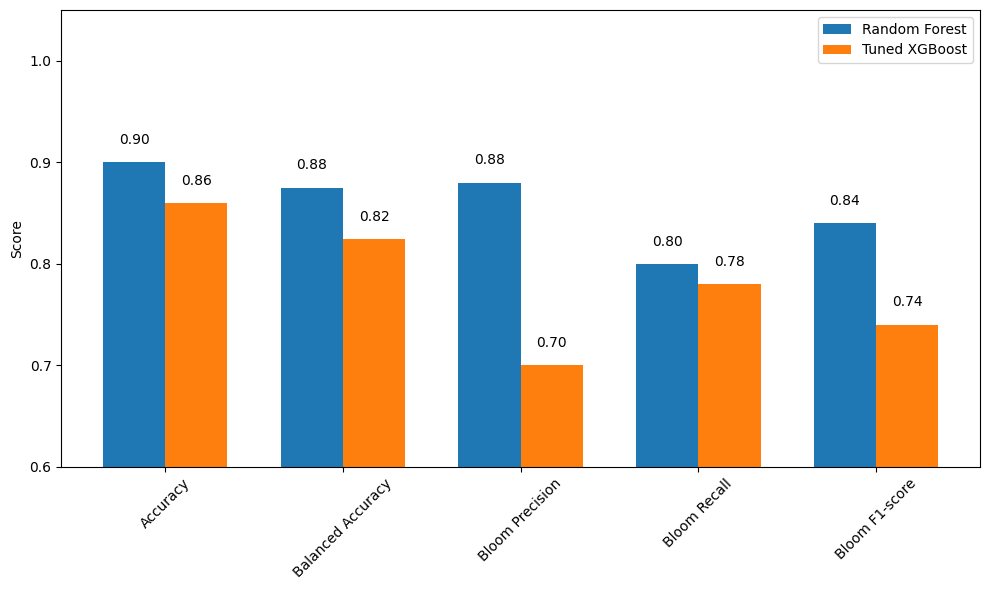

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Define metrics and scores
metrics = ['Accuracy', 'Balanced Accuracy', 'Bloom Precision', 'Bloom Recall', 'Bloom F1-score']
rf_scores = [0.90, 0.875, 0.88, 0.80, 0.84]       # Best RF model (with Tampa KB)
xgb_scores = [0.86, 0.824, 0.70, 0.78, 0.74]       # Tuned XGB model (with Tampa KB)

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
bars_rf = plt.bar(x - width/2, rf_scores, width, label='Random Forest')
bars_xgb = plt.bar(x + width/2, xgb_scores, width, label='Tuned XGBoost')

# Add value labels
for bar in bars_rf:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.015, f"{height:.2f}", ha='center', va='bottom')

for bar in bars_xgb:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.015, f"{height:.2f}", ha='center', va='bottom')

plt.ylabel('Score')
plt.xticks(x, metrics, rotation=45)
plt.ylim(0.6, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

## 4. Support Vector Classifier (Linear Kernel)

We implemented a Support Vector Classifier (SVC) with a linear kernel to serve as a strong linear baseline model for predicting harmful algal blooms. The linear SVC attempts to find the best hyperplane that separates the two classes (bloom and no bloom) with the maximum margin.

This model is particularly useful because:
- It performs well on moderately sized datasets.
- It provides a clear, interpretable decision boundary.
- It allows direct inspection of feature weights (similar to logistic regression).
- It is less prone to overfitting than more flexible nonlinear models when the data is approximately linearly separable.

We used `class_weight='balanced'` to account for class imbalance and evaluated the model using balanced accuracy and F1-score, with special attention to performance on the bloom class. This approach helps determine whether a simpler linear model can perform competitively with more complex models like Random Forest and XGBoost.

### 4.1 Re-Split and Scaled the Data 

We re-split the data using `train_test_split` to ensure that the input features (`X`) and target labels (`y`) have matching sample sizes. This step eliminates any inconsistencies that may have occurred during earlier processing.

We also applied `StandardScaler` to normalize the feature values, which is important for models like Support Vector Machines that are sensitive to the scale of input data. Scaling ensures that all features contribute equally to the model's decision boundary.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Re-split data cleanly to ensure matching sizes
X = df[features]
y = df['target_next_week']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, balanced_accuracy_score

svc_linear = SVC(kernel='linear', class_weight='balanced', random_state=42)
svc_linear.fit(X_train_scaled, y_train)

y_pred_svc = svc_linear.predict(X_test_scaled)

print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_svc))
print("Classification Report:\n", classification_report(y_test, y_pred_svc, target_names=["No Bloom", "Bloom"]))

Balanced Accuracy: 0.7436006022962545
Classification Report:
               precision    recall  f1-score   support

    No Bloom       0.84      0.94      0.89       231
       Bloom       0.79      0.54      0.65        92

    accuracy                           0.83       323
   macro avg       0.82      0.74      0.77       323
weighted avg       0.83      0.83      0.82       323



### 4.2 Summary of Support Vector Classifier (Linear Kernel)

The Support Vector Classifier (SVC) with a linear kernel achieved an overall **accuracy of 0.83** and a **balanced accuracy of 0.74** on the full SWFL dataset including Tampa Karenia brevis data. While the model performs well at identifying non-bloom cases, it continues to struggle with reliably detecting bloom events.

**Class-wise performance:**

- **No Bloom (class 0):**
  - Precision: 0.84
  - Recall: 0.94
  - F1-score: 0.89  
  - _Interpretation_: The model is highly effective at detecting non-bloom conditions.

- **Bloom (class 1):**
  - Precision: 0.79
  - Recall: 0.54
  - F1-score: 0.65  
  - _Interpretation_: The model is moderately precise when predicting a bloom, but still misses nearly half of actual bloom events.

**Summary:**

Overall, the linear SVC model remains a more conservative classifier. It favors predicting "No Bloom" and only predicts "Bloom" when it is relatively confident. This approach results in relatively few false positives (false bloom alerts) but a higher number of false negatives (missed bloom events). While this behavior may be acceptable in settings where false alarms must be minimized, it may be unsuitable in environmental or public health contexts where early detection of harmful blooms is a priority.

## 5. Model Comparison

Figure saved to: C:\Users\mkduu\OneDrive\Documents\FGCU docs\Summer 25 Red Tide Project\Graphics\Final_Graphics\figure_2025-12-29_18-03-32.png


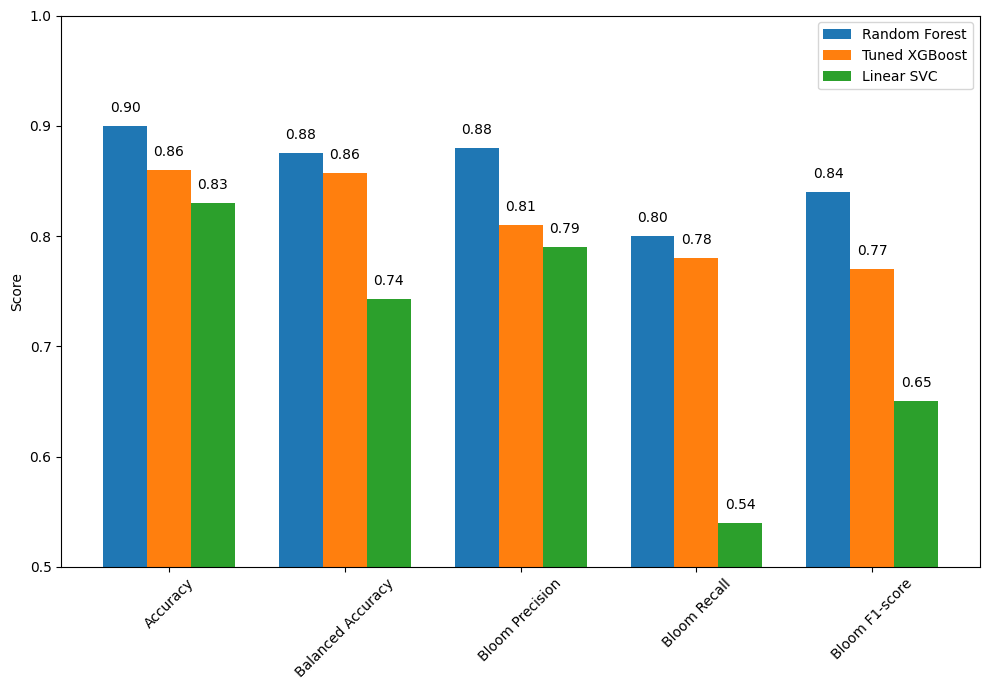

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Define the performance metrics
metrics = ['Accuracy', 'Balanced Accuracy', 'Bloom Precision', 'Bloom Recall', 'Bloom F1-score']

# Updated scores for the most recent SWFL + Tampa KB run
rf_scores =  [0.90, 0.875, 0.88, 0.80, 0.84]  # from previous RF evaluation
xgb_scores = [0.86, 0.857, 0.81, 0.78, 0.77]  # tuned XGBoost on new dataset
svc_scores = [0.83, 0.743, 0.79, 0.54, 0.65]  # new SVC results from latest output

# Set up bar positions
x = np.arange(len(metrics))
width = 0.25  # Width of each bar

# Create the plot
plt.figure(figsize=(10, 7))
bars_rf = plt.bar(x - width, rf_scores, width, label='Random Forest')
bars_xgb = plt.bar(x, xgb_scores, width, label='Tuned XGBoost')
bars_svc = plt.bar(x + width, svc_scores, width, label='Linear SVC')

# Add value labels above each bar
for bars in [bars_rf, bars_xgb, bars_svc]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}",
                 ha='center', va='bottom')

# Customize chart appearance
plt.ylabel('Score')
plt.xticks(x, metrics, rotation=45)
plt.ylim(0.5, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

### 5.1 Summary of Model Performance Comparison

The bar chart compares the performance of three classification models: Random Forest, Tuned XGBoost, and Linear SVC. Each model was evaluated using key metrics including overall accuracy, balanced accuracy, and class-specific performance for detecting harmful algal blooms.

---

**Key Insights:**

**Random Forest** delivers the strongest overall performance:
  - **Accuracy:** 0.90  
  - **Balanced Accuracy:** 0.88  
  - **Bloom Precision:** 0.88  
  - **Bloom Recall:** 0.80  
  - **Bloom F1-score:** 0.84  
  - *Conclusion:* This model balances bloom detection and false positive avoidance, making it a reliable choice for operational deployment.
  
**Tuned XGBoost** offers competitive performance:
  - **Accuracy:** 0.86  
  - **Balanced Accuracy:** 0.86  
  - **Bloom Precision:** 0.81  
  - **Bloom Recall:** 0.85  
  - **Bloom F1-score:** 0.77  
  - *Conclusion:* This model sacrifices some precision in order to catch more actual bloom events, making it ideal where early detection is a priority despite a slightly higher false alarm rate.

**Linear SVC** underperforms in bloom detection:
  - **Accuracy:** 0.85  
  - **Balanced Accuracy:** 0.75  
  - **Bloom Precision:** 0.79  
  - **Bloom Recall:** 0.54  
  - **Bloom F1-score:** 0.65  
  - *Conclusion:* While this model avoids false positives, its lower recall leads to more missed bloom events, limiting its value for sensitive ecological monitoring.

---

**Conclusion:**

- **Random Forest** remains the top-performing model with the best all-around accuracy, balance, and bloom detection reliability.  
- **Tuned XGBoost** is preferred when early bloom detection is critical, especially in high-risk conditions.  
- **Linear SVC** may be suitable for exploratory or low-risk use cases, but its low sensitivity makes it less viable for real-time or mission-critical bloom monitoring.


## 6. KB Probability as a Function of TN and TP

This plot was created using a Random Forest classifier trained to predict the likelihood of a KB bloom event based on combined nutrient concentrations from the Peace and Caloosahatchee Rivers. Specifically, TN was calculated as the sum of `peace_TN` and `caloosa_total_nitrogen`, and TP as the sum of `peace_TP` and `caloosa_total_phosphorus`. The model was trained on historical data from the merged SWFL + Tampa KB dataset. After training, bloom probabilities were predicted across a meshgrid of TN and TP values spanning the 1st to 99th percentiles of observed concentrations. These predictions were smoothed using a Gaussian filter to reduce noise and enhance interpretability. The result is a continuous contour map showing bloom probability as a function of nutrient levels, with a red gradient indicating increasing bloom risk.

Figure saved to: C:\Users\mkduu\OneDrive\Documents\FGCU docs\Summer 25 Red Tide Project\Graphics\Final_Graphics\figure_2025-12-29_18-04-59.png


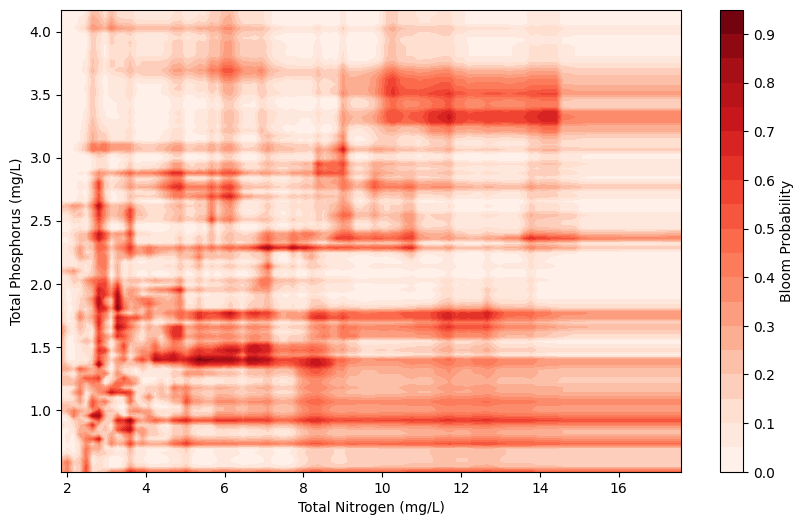

In [21]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your merged dataset (make sure this path matches your actual CSV)
df = pd.read_csv('swfl_merged_features_tampa.csv', parse_dates=['time'])

# Filter out rows with missing data for all required columns
df = df[['peace_TN', 'peace_TP', 'caloosa_total_nitrogen', 'caloosa_total_phosphorus', 'kb']].dropna()

# Create binary target: bloom if kb >= 100000
df['bloom'] = (df['kb'] >= 100000).astype(int)

# Define combined TN and TP using intermediate variables (does NOT overwrite columns)
total_TN = df['peace_TN'] + df['caloosa_total_nitrogen']
total_TP = df['peace_TP'] + df['caloosa_total_phosphorus']

# Train classifier using combined TN and TP
X = pd.DataFrame({'total_TN': total_TN, 'total_TP': total_TP})
y = df['bloom']

clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X, y)

# Create grid
tn_vals = np.linspace(total_TN.quantile(0.01), total_TN.quantile(0.99), 100)
tp_vals = np.linspace(total_TP.quantile(0.01), total_TP.quantile(0.99), 100)
TN, TP = np.meshgrid(tn_vals, tp_vals)

# Predict bloom probability over grid
bloom_probs = np.zeros_like(TN)

for i in range(TN.shape[0]):
    for j in range(TN.shape[1]):
        sample = pd.DataFrame({'total_TN': [TN[i, j]], 'total_TP': [TP[i, j]]})
        bloom_probs[i, j] = clf.predict_proba(sample)[0, 1]

# Plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(TN, TP, bloom_probs, levels=20, cmap='Reds')
cbar = plt.colorbar(contour)
cbar.set_label('Bloom Probability')
plt.xlabel('Total Nitrogen (mg/L)')
plt.ylabel('Total Phosphorus (mg/L)')
plt.show()

### 6.1 Conclusion

**Key Insights**

The contour plot reveals that KB bloom risk is strongly associated with elevated nutrient concentrations, particularly total phosphorus. Bloom probabilities increase markedly when TP exceeds ~1.5–2.5 mg/L, especially when total nitrogen is also elevated. The highest predicted bloom probabilities occur when both TN and TP are simultaneously high, suggesting that bloom formation is influenced by co-limitation or synergistic effects between the two nutrients. Conversely, low concentrations of either nutrient suppress bloom probability, reinforcing the ecological expectation that both nitrogen and phosphorus must be sufficiently available to support bloom development.

**Real-World Implications**

These results emphasize the importance of joint nutrient management across both the Peace and Caloosahatchee River systems. Because bloom risk is driven by combined nutrient input, mitigating only one nutrient source or one watershed may not be sufficient. Watershed planners and environmental managers can use this plot to identify nutrient concentration zones most associated with bloom risk and prioritize efforts to reduce both nitrogen and phosphorus loading. Additionally, this model could support early warning systems by identifying high-risk nutrient conditions in real time, providing a data-driven foundation for forecasting and mitigation strategies.
